In [1]:
# Ignore Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")

# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import re
import time
import warnings
from tqdm import tqdm
import datetime as dt
import pandas_datareader as web
from datetime import datetime
import scipy.stats as stats
from pathlib import Path

# ML/DL imports
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# BITCOIN

In [2]:
url = 'https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_1h.csv'
dataset = pd.read_csv(url, index_col="date", skiprows=1)
#dataset = pd.read_csv('Gemini_BTCUSD_1h.csv', index_col="date", skiprows=1)
dataset.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-08-25 00:00:00,1661385600000,BTC/USD,21368.63,21485.59,21314.24,21472.61,36.305121,7.795657e+05
2022-08-24 23:00:00,1661382000000,BTC/USD,21492.32,21535.44,21368.63,21368.63,30.155089,6.443729e+05
2022-08-24 22:00:00,1661378400000,BTC/USD,21589.19,21660.58,21459.95,21492.32,77.126443,1.657626e+06
2022-08-24 21:00:00,1661374800000,BTC/USD,21691.95,21730.10,21560.65,21589.19,36.171399,7.809112e+05
2022-08-24 20:00:00,1661371200000,BTC/USD,21710.70,21767.00,21682.75,21691.95,35.872016,7.781340e+05


In [3]:
dataset = dataset.iloc[::-1]

dataset.head()



,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2015-10-08 13:00:00,1444309200,BTC/USD,0.00,245.00,0.00,245.00,0.606654,148.630323
2015-10-08 14:00:00,1444312800,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1091.143988
2015-10-08 15:00:00,1444316400,BTC/USD,245.00,245.00,244.92,244.92,3.016926,738.905474
2015-10-08 16:00:00,1444320000,BTC/USD,244.92,244.92,244.25,244.25,3.895252,951.415413
2015-10-08 17:00:00,1444323600,BTC/USD,244.25,244.99,244.02,244.99,3.920632,960.515634


In [4]:
df = dataset.reset_index()
df

,date,unix,symbol,open,high,low,close,Volume BTC,Volume USD
0,2015-10-08 13:00:00,1444309200,BTC/USD,0.00,245.00,0.00,245.00,0.606654,1.486303e+02
1,2015-10-08 14:00:00,1444312800,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1.091144e+03
2,2015-10-08 15:00:00,1444316400,BTC/USD,245.00,245.00,244.92,244.92,3.016926,7.389055e+02
3,2015-10-08 16:00:00,1444320000,BTC/USD,244.92,244.92,244.25,244.25,3.895252,9.514154e+02
4,2015-10-08 17:00:00,1444323600,BTC/USD,244.25,244.99,244.02,244.99,3.920632,9.605156e+02
...,...,...,...,...,...,...,...,...,...
60292,2022-08-24 20:00:00,1661371200000,BTC/USD,21710.70,21767.00,21682.75,21691.95,35.872016,7.781340e+05
60293,2022-08-24 21:00:00,1661374800000,BTC/USD,21691.95,21730.10,21560.65,21589.19,36.171399,7.809112e+05
60294,2022-08-24 22:00:00,1661378400000,BTC/USD,21589.19,21660.58,21459.95,21492.32,77.126443,1.657626e+06
60295,2022-08-24 23:00:00,1661382000000,BTC/USD,21492.32,21535.44,21368.63,21368.63,30.155089,6.443729e+05


In [5]:
#plt.figure(figsize=(12,6))
#sns.lineplot(x='date', y='close', data=df).set_title("Price of Bitcoin")
df

,date,unix,symbol,open,high,low,close,Volume BTC,Volume USD
0,2015-10-08 13:00:00,1444309200,BTC/USD,0.00,245.00,0.00,245.00,0.606654,1.486303e+02
1,2015-10-08 14:00:00,1444312800,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1.091144e+03
2,2015-10-08 15:00:00,1444316400,BTC/USD,245.00,245.00,244.92,244.92,3.016926,7.389055e+02
3,2015-10-08 16:00:00,1444320000,BTC/USD,244.92,244.92,244.25,244.25,3.895252,9.514154e+02
4,2015-10-08 17:00:00,1444323600,BTC/USD,244.25,244.99,244.02,244.99,3.920632,9.605156e+02
...,...,...,...,...,...,...,...,...,...
60292,2022-08-24 20:00:00,1661371200000,BTC/USD,21710.70,21767.00,21682.75,21691.95,35.872016,7.781340e+05
60293,2022-08-24 21:00:00,1661374800000,BTC/USD,21691.95,21730.10,21560.65,21589.19,36.171399,7.809112e+05
60294,2022-08-24 22:00:00,1661378400000,BTC/USD,21589.19,21660.58,21459.95,21492.32,77.126443,1.657626e+06
60295,2022-08-24 23:00:00,1661382000000,BTC/USD,21492.32,21535.44,21368.63,21368.63,30.155089,6.443729e+05


In [6]:
df = df[["open", "high", "low", "close","Volume BTC", "Volume USD"]]
#df = df[['Close']]
df.head()
SEQ_LEN = 120
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"
df

,open,high,low,close,Volume BTC,Volume USD
0,0.00,245.00,0.00,245.00,0.606654,1.486303e+02
1,245.00,245.00,244.50,245.00,4.453649,1.091144e+03
2,245.00,245.00,244.92,244.92,3.016926,7.389055e+02
3,244.92,244.92,244.25,244.25,3.895252,9.514154e+02
4,244.25,244.99,244.02,244.99,3.920632,9.605156e+02
...,...,...,...,...,...,...
60292,21710.70,21767.00,21682.75,21691.95,35.872016,7.781340e+05
60293,21691.95,21730.10,21560.65,21589.19,36.171399,7.809112e+05
60294,21589.19,21660.58,21459.95,21492.32,77.126443,1.657626e+06
60295,21492.32,21535.44,21368.63,21368.63,30.155089,6.443729e+05


In [7]:
times = sorted(df.index.values)  # get the times
last_10 = times[-int(0.1*len(times))] 
last_20 = times[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)]

In [8]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values
df

,open,high,low,close,Volume BTC,Volume USD
0,0.00,245.00,0.00,245.00,0.606654,1.486303e+02
1,245.00,245.00,244.50,245.00,4.453649,1.091144e+03
2,245.00,245.00,244.92,244.92,3.016926,7.389055e+02
3,244.92,244.92,244.25,244.25,3.895252,9.514154e+02
4,244.25,244.99,244.02,244.99,3.920632,9.605156e+02
...,...,...,...,...,...,...
60292,21710.70,21767.00,21682.75,21691.95,35.872016,7.781340e+05
60293,21691.95,21730.10,21560.65,21589.19,36.171399,7.809112e+05
60294,21589.19,21660.58,21459.95,21492.32,77.126443,1.657626e+06
60295,21492.32,21535.44,21368.63,21368.63,30.155089,6.443729e+05


In [9]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))


train shape (48238, 6)
valid shape (6030, 6)
test shape (6029, 6)


In [10]:
def line_plot(line1, line2,line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

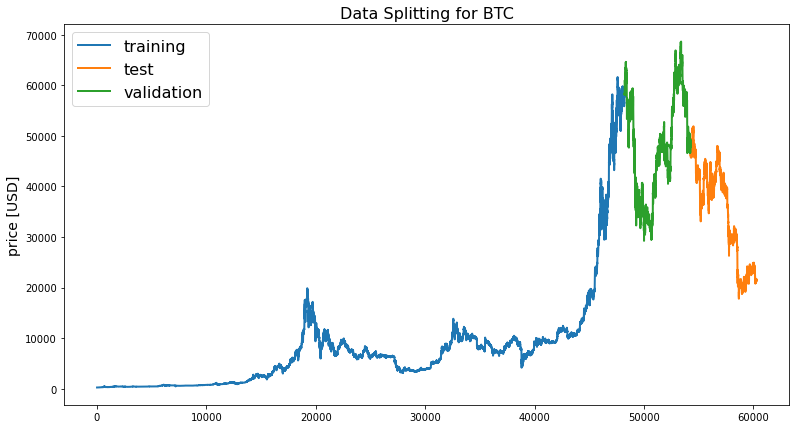

In [11]:
line_plot(train_df['close'], test_df['close'], validation_df['close'], 'training', 'test','validation', title='Data Splitting for BTC')

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [13]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler()

In [14]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [15]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.165
for ti in range(train_.shape[0]):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [16]:
#data splitting

def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [17]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)


In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [19]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (48109, 120, 6)
valid shape (5901, 120, 6)
test shape (5900, 120, 6)


In [20]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

In [21]:
#LSTM model

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization

# Initialize the RNN
model_LSTM1 = Sequential()
model_LSTM1.add(LSTM(units = 120, input_shape=(120, 6)))
model_LSTM1.add(LeakyReLU(alpha=0.5))
model_LSTM1.add(Dropout(0.5))
model_LSTM1.add(BatchNormalization())
model_LSTM1.add(Dense(1))
model_LSTM1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               60960     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120)               0         
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 61,561
Trainable params: 61,321
Non-trainable params: 240
__________________________________________________

In [22]:
model_LSTM1.compile(optimizer='adam', loss='mean_squared_error', metrics = ('MAPE'))

In [23]:
history_LSTM1 = model_LSTM1.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

Epoch 1/10
376/376 [==============================] - 159s 409ms/step - loss: 0.0490 - MAPE: 703.6752 - val_loss: 0.2751 - val_MAPE: 65.2686
Epoch 2/10
376/376 [==============================] - 149s 397ms/step - loss: 0.0019 - MAPE: 223.0942 - val_loss: 0.0224 - val_MAPE: 18.1761
Epoch 3/10
376/376 [==============================] - 155s 414ms/step - loss: 0.0014 - MAPE: 196.3655 - val_loss: 0.0016 - val_MAPE: 3.9651
Epoch 4/10
376/376 [==============================] - 192s 508ms/step - loss: 0.0013 - MAPE: 197.5495 - val_loss: 0.0011 - val_MAPE: 3.5205
Epoch 5/10
376/376 [==============================] - 175s 465ms/step - loss: 0.0015 - MAPE: 211.6348 - val_loss: 0.0062 - val_MAPE: 9.5642
Epoch 6/10
376/376 [==============================] - 162s 430ms/step - loss: 0.0011 - MAPE: 191.0901 - val_loss: 7.7927e-04 - val_MAPE: 2.7630
Epoch 7/10
376/376 [==============================] - 165s 439ms/step - loss: 0.0011 - MAPE: 186.2559 - val_loss: 9.2973e-04 - val_MAPE: 3.1847
Epoch 8/10

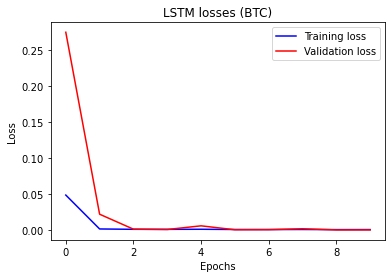

In [24]:
loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("LSTM losses (BTC)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

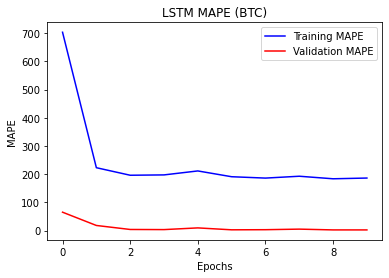

In [25]:
mape = history_LSTM1.history['MAPE']
val_mape = history_LSTM1.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("LSTM MAPE (BTC)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [26]:
pred_LSTM1 = model_LSTM1.predict(X_test)


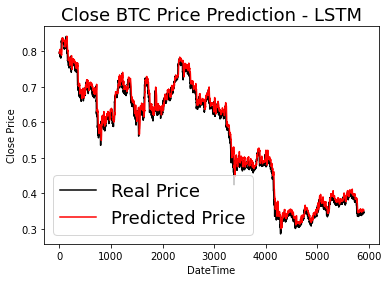

In [27]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_LSTM1, color = 'red', label = 'Predicted Price')
plt.title('Close BTC Price Prediction - LSTM', fontsize=18)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [28]:
import math

LSTM1_loss = model_LSTM1.evaluate(X_test, y_test, verbose=1)

#Err_LSTM1 = LSTM1_loss[0]
#Err_LSTM1 = math.sqrt(LSTM1_loss)
print('\nThe error of the model with 1 layer LSTM is:',LSTM1_loss)

185/185 [==============================] - 7s 37ms/step - loss: 3.0479e-04 - MAPE: 2.6099

The error of the model with 1 layer LSTM is: [0.0003047852369491011, 2.609872817993164]


In [29]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_LSTM1, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_LSTM1)
print (MAE,R2)

0.00030478523871327654 0.9869150285775621


In [30]:
#GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU,CuDNNGRU
model_GRU = Sequential()

model_GRU.add(GRU(units=50, input_shape=(120,6),return_sequences=False))
model_GRU.add(Activation('tanh'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(1))
model_GRU.add(Activation('relu'))
model_GRU.compile(loss='mse', optimizer='adam', metrics = ('MAPE'))
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8700      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 8,751
Trainable params: 8,751
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 128, epochs = 10)

Epoch 1/10
376/376 [==============================] - 78s 195ms/step - loss: 0.0011 - MAPE: 55.6439 - val_loss: 4.9223e-04 - val_MAPE: 2.3015
Epoch 2/10
376/376 [==============================] - 100s 266ms/step - loss: 3.8664e-04 - MAPE: 34.2880 - val_loss: 5.3675e-04 - val_MAPE: 2.3868
Epoch 3/10
376/376 [==============================] - 93s 247ms/step - loss: 3.2261e-04 - MAPE: 37.8920 - val_loss: 6.3255e-04 - val_MAPE: 2.5709
Epoch 4/10
376/376 [==============================] - 111s 296ms/step - loss: 2.7350e-04 - MAPE: 41.3545 - val_loss: 5.0426e-04 - val_MAPE: 2.3333
Epoch 5/10
376/376 [==============================] - 103s 273ms/step - loss: 2.9255e-04 - MAPE: 46.6297 - val_loss: 5.2061e-04 - val_MAPE: 2.2284
Epoch 6/10
376/376 [==============================] - 100s 266ms/step - loss: 2.6061e-04 - MAPE: 44.8427 - val_loss: 8.2097e-04 - val_MAPE: 2.8472
Epoch 7/10
376/376 [==============================] - 100s 267ms/step - loss: 2.6548e-04 - MAPE: 46.8879 - val_loss: 6.8610e

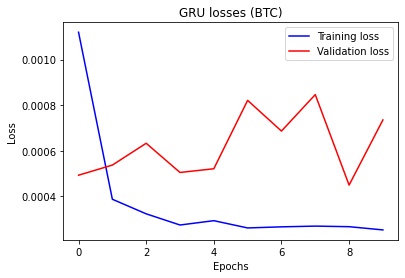

In [32]:
loss_GRU = history_GRU.history['loss']
val_loss_GRU = history_GRU.history['val_loss']

epochs = range(len(loss_GRU))

plt.figure()

plt.plot(epochs, loss_GRU, 'b', label='Training loss')
plt.plot(epochs, val_loss_GRU, 'r', label='Validation loss')
plt.title("GRU losses (BTC)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

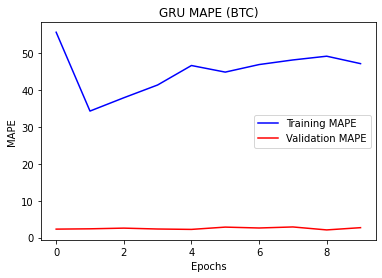

In [33]:
mape = history_GRU.history['MAPE']
val_mape = history_GRU.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("GRU MAPE (BTC)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [ ]:
pred_GRU = model_GRU.predict(X_test)

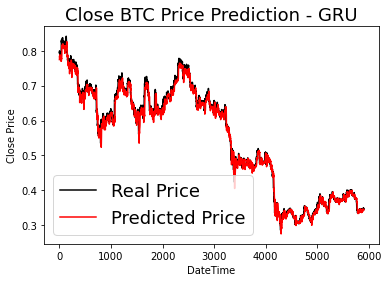

In [51]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_GRU, color = 'red', label = 'Predicted Price')
plt.title('Close BTC Price Prediction - GRU', fontsize=18)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [36]:


import math

GRU_loss = model_GRU.evaluate(X_test, y_test, verbose=1)

#Err_GRU = math.sqrt(GRU_loss)
print('\nThe error of the model with a GRU layer is:',GRU_loss)

185/185 [==============================] - 30s 165ms/step - loss: 1.9779e-04 - MAPE: 1.8374

The error of the model with a GRU layer is: [0.00019779166905209422, 1.8373764753341675]


In [37]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_GRU, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_GRU)
print (MAE,R2)

0.00019779170789103133 0.9915084508151523


In [38]:
#Bi-LSTM
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Bidirectional

num_units = 128
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 128
num_epochs = 10

# Initialize the RNN
regressor2 = Sequential()

# Adding the input layer and the LSTM layer
#regressor2.add(tf.keras.layers.Conv1D(120, 3, activation="relu",input_shape=(120, 5)))
#regressor2.add(tf.keras.layers.AveragePooling1D(4))
regressor2.add(Bidirectional(LSTM(units = num_units, input_shape=(120, 6))))#activation = activation_function,
regressor2.add(LeakyReLU(alpha= 0.5))
regressor2.add(BatchNormalization())
regressor2.add(Dropout(0.5))
# Adding the output layer
regressor2.add(Dense(units = 1))
# Compiling the RNN
regressor2.compile(optimizer = optimizer, loss = loss_function, metrics = ('MAPE'))

In [39]:
# Using the training set to train the model
history_BiLSTM2 = regressor2.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = batch_size, epochs = num_epochs)

Epoch 1/10
376/376 [==============================] - 354s 907ms/step - loss: 0.0428 - MAPE: 861.1832 - val_loss: 0.2898 - val_MAPE: 67.2097
Epoch 2/10
376/376 [==============================] - 275s 731ms/step - loss: 0.0020 - MAPE: 226.7015 - val_loss: 0.0061 - val_MAPE: 8.6389
Epoch 3/10
376/376 [==============================] - 204s 543ms/step - loss: 0.0010 - MAPE: 163.6756 - val_loss: 0.0102 - val_MAPE: 12.2169
Epoch 4/10
376/376 [==============================] - 224s 595ms/step - loss: 9.3990e-04 - MAPE: 163.4554 - val_loss: 8.9312e-04 - val_MAPE: 3.0126
Epoch 5/10
376/376 [==============================] - 268s 712ms/step - loss: 0.0010 - MAPE: 178.3982 - val_loss: 7.9492e-04 - val_MAPE: 2.8495
Epoch 6/10
376/376 [==============================] - 227s 605ms/step - loss: 8.7513e-04 - MAPE: 160.9424 - val_loss: 0.0055 - val_MAPE: 9.0410
Epoch 7/10
376/376 [==============================] - 240s 637ms/step - loss: 8.5945e-04 - MAPE: 164.6934 - val_loss: 0.0034 - val_MAPE: 6.840

In [40]:
regressor2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              138240    
 l)                                                              
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,521
Trainable params: 139,009
Non-tr

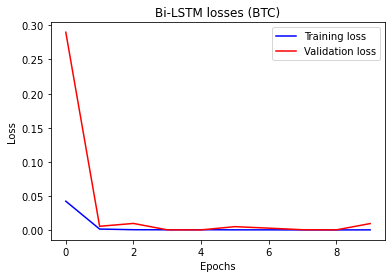

In [41]:
loss_BiLSTM2 = history_BiLSTM2.history['loss']
val_loss_BiLSTM2 = history_BiLSTM2.history['val_loss']

epochs = range(len(loss_BiLSTM2))

plt.figure()

plt.plot(epochs, loss_BiLSTM2, 'b', label='Training loss')
plt.plot(epochs, val_loss_BiLSTM2, 'r', label='Validation loss')
plt.title("Bi-LSTM losses (BTC)")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

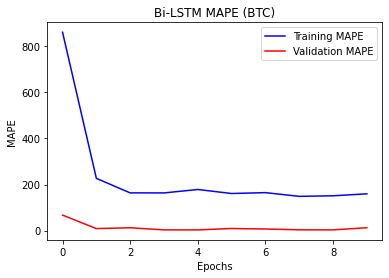

In [42]:
mape = history_BiLSTM2.history['MAPE']
val_mape = history_BiLSTM2.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Bi-LSTM MAPE (BTC)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [43]:
pred_BiLSTM2 = regressor2.predict(X_test)

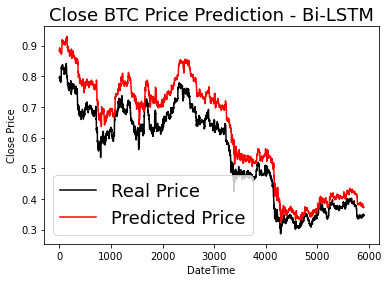

In [44]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_BiLSTM2, color = 'red', label = 'Predicted Price')
plt.title('Close BTC Price Prediction - Bi-LSTM', fontsize=18)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [45]:
import math

BiLSTM2_loss = regressor2.evaluate(X_test, y_test, verbose=1)
print('\nThe error of the model with 1 layer BiLSTM is:',BiLSTM2_loss)

185/185 [==============================] - 6s 34ms/step - loss: 0.0051 - MAPE: 11.5204

The error of the model with 1 layer BiLSTM is: [0.005087385885417461, 11.520392417907715]


In [46]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_BiLSTM2, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_BiLSTM2)
print (MAE,R2)

0.005087385470241495 0.7815895094720798


# ethereum

In [47]:
url = 'https://www.cryptodatadownload.com/cdd/Gemini_ETHUSD_1h.csv'
dataset = pd.read_csv(url, index_col="date", skiprows=1)
#dataset = pd.read_csv('Gemini_ETHUSD_1h.csv', index_col="date", skiprows=1)
dataset.head()

,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2022-08-25 00:00:00,1661385600000,ETH/USD,1656.40,1672.51,1655.12,1669.66,400.576414,6.688264e+05
2022-08-24 23:00:00,1661382000000,ETH/USD,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05
2022-08-24 22:00:00,1661378400000,ETH/USD,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
2022-08-24 21:00:00,1661374800000,ETH/USD,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
2022-08-24 20:00:00,1661371200000,ETH/USD,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05


In [48]:
dataset = dataset.iloc[::-1]

dataset.head()



,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4130.968200
2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2357.740748
2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,109.625935
2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,613.189994
2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3127.459991


In [49]:
df = dataset.reset_index()
df

,date,unix,symbol,open,high,low,close,Volume ETH,Volume USD
0,2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4.130968e+03
1,2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2.357741e+03
2,2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,1.096259e+02
3,2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,6.131900e+02
4,2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3.127460e+03
...,...,...,...,...,...,...,...,...,...
55156,2022-08-24 20:00:00,1661371200000,ETH/USD,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05
55157,2022-08-24 21:00:00,1661374800000,ETH/USD,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
55158,2022-08-24 22:00:00,1661378400000,ETH/USD,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
55159,2022-08-24 23:00:00,1661382000000,ETH/USD,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05


In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='close', data=df).set_title("Price of Ethereum")
df

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000018310D174C0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
df = df[["open", "high", "low", "close","Volume ETH", "Volume USD"]]
#df = df[['Close']]
df.head()
SEQ_LEN = 120
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"
df

In [ ]:
times = sorted(df.index.values)  # get the times
last_10 = times[-int(0.1*len(times))] 
last_20 = times[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)]

In [ ]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values
df

In [ ]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))


In [ ]:
def line_plot(line1, line2,line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
line_plot(train_df['close'], test_df['close'], validation_df['close'], 'training', 'test','validation', title='')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [ ]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

In [ ]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [ ]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.165
for ti in range(train_.shape[0]):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [ ]:
#data splitting

def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [ ]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

In [ ]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

In [ ]:
#LSTM model

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization

# Initialize the RNN
model_LSTM1 = Sequential()
model_LSTM1.add(LSTM(units = 120, input_shape=(120, 6)))
model_LSTM1.add(LeakyReLU(alpha=0.5))
model_LSTM1.add(Dropout(0.5))
model_LSTM1.add(BatchNormalization())
model_LSTM1.add(Dense(1))
model_LSTM1.summary()

In [ ]:
model_LSTM1.compile(optimizer='adam', loss='mean_squared_error', metrics = ('MAPE'))

In [ ]:
history_LSTM1 = model_LSTM1.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

In [ ]:
loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_LSTM1.history['MAPE']
val_mape = history_LSTM1.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_LSTM1 = model_LSTM1.predict(X_test)


In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_LSTM1, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
import math

LSTM1_loss = model_LSTM1.evaluate(X_test, y_test, verbose=1)

#Err_LSTM1 = LSTM1_loss[0]
#Err_LSTM1 = math.sqrt(LSTM1_loss)
print('\nThe error of the model with 1 layer LSTM is:',LSTM1_loss)

In [ ]:
#GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU,CuDNNGRU
model_GRU = Sequential()

model_GRU.add(GRU(units=50, input_shape=(120,6),return_sequences=False))
model_GRU.add(Activation('tanh'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(1))
model_GRU.add(Activation('relu'))
model_GRU.compile(loss='mse', optimizer='adam', metrics = ('MAPE'))
model_GRU.summary()

In [ ]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 128, epochs = 10)

In [ ]:
loss_GRU = history_GRU.history['loss']
val_loss_GRU = history_GRU.history['val_loss']

epochs = range(len(loss_GRU))

plt.figure()

plt.plot(epochs, loss_GRU, 'b', label='Training loss')
plt.plot(epochs, val_loss_GRU, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_GRU.history['MAPE']
val_mape = history_GRU.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_GRU = model_GRU.predict(X_test)

In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_GRU, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:


import math

GRU_loss = model_GRU.evaluate(X_test, y_test, verbose=1)

#Err_GRU = math.sqrt(GRU_loss)
print('\nThe error of the model with a GRU layer is:',GRU_loss)

In [ ]:
#CNN-BiLSTM
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Bidirectional

num_units = 128
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 128
num_epochs = 10

# Initialize the RNN
regressor2 = Sequential()

# Adding the input layer and the LSTM layer
regressor2.add(tf.keras.layers.Conv1D(120, 3, activation="relu",input_shape=(120, 6)))
regressor2.add(tf.keras.layers.AveragePooling1D(4))
regressor2.add(Bidirectional(LSTM(units = num_units, input_shape=(120, 6))))
regressor2.add(LeakyReLU(alpha= 0.5))
regressor2.add(BatchNormalization())
regressor2.add(Dropout(0.5))
# Adding the output layer
regressor2.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor2.compile(optimizer = optimizer, loss = loss_function, metrics = ('MAPE'))
regressor2.summary()

# Using the training set to train the model
history_BiLSTM2 = regressor2.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = batch_size, epochs = num_epochs)

In [ ]:
loss_BiLSTM2 = history_BiLSTM2.history['loss']
val_loss_BiLSTM2 = history_BiLSTM2.history['val_loss']

epochs = range(len(loss_BiLSTM2))

plt.figure()

plt.plot(epochs, loss_BiLSTM2, 'b', label='Training loss')
plt.plot(epochs, val_loss_BiLSTM2, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_BiLSTM2.history['MAPE']
val_mape = history_BiLSTM2.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_BiLSTM2 = regressor2.predict(X_test)

In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_BiLSTM2, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
import math

BiLSTM2_loss = regressor2.evaluate(X_test, y_test, verbose=1)

#Err_BiLSTM2 = math.sqrt(BiLSTM2_loss)
print('\nThe error of the model with 1 layer BiLSTM is:',BiLSTM2_loss)

# Cardano

In [ ]:
url = 'https://www.cryptodatadownload.com/cdd/Bittrex_ADAUSD_1h.csv'
dataset = pd.read_csv(url, index_col="date", skiprows=1)
#dataset = pd.read_csv('Gemini_BTCUSD_1h.csv', index_col="date", skiprows=1)
dataset.head()

In [ ]:
dataset = dataset.iloc[::-1]

dataset.head()



In [ ]:
df = dataset.reset_index()
df

In [ ]:
#plt.figure(figsize=(12,6))
#sns.lineplot(x='date', y='close', data=df).set_title("Price of Bitcoin")
df

In [ ]:
df = df[["open", "high", "low", "close","Volume ADA", "Volume USD"]]
#df = df[['Close']]
df.head()
SEQ_LEN = 120
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"
df

In [ ]:
times = sorted(df.index.values)  # get the times
last_10 = times[-int(0.1*len(times))] 
last_20 = times[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)]

In [ ]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values
df

In [ ]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))


In [ ]:
def line_plot(line1, line2,line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
line_plot(train_df['close'], test_df['close'], validation_df['close'], 'training', 'test','validation', title='')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [ ]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

In [ ]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [ ]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.165
for ti in range(train_.shape[0]):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [ ]:
#data splitting

def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [ ]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

In [ ]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

In [ ]:
#LSTM model

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization

# Initialize the RNN
model_LSTM1 = Sequential()
model_LSTM1.add(LSTM(units = 120, input_shape=(120, 6)))
model_LSTM1.add(LeakyReLU(alpha=0.5))
model_LSTM1.add(Dropout(0.5))
model_LSTM1.add(BatchNormalization())
model_LSTM1.add(Dense(1))
model_LSTM1.summary()

In [ ]:
model_LSTM1.compile(optimizer='adam', loss='mean_squared_error', metrics = ('MAPE'))

In [ ]:
history_LSTM1 = model_LSTM1.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

In [ ]:
loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_LSTM1.history['MAPE']
val_mape = history_LSTM1.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_LSTM1 = model_LSTM1.predict(X_test)


In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_LSTM1, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
import math

LSTM1_loss = model_LSTM1.evaluate(X_test, y_test, verbose=1)

#Err_LSTM1 = LSTM1_loss[0]
#Err_LSTM1 = math.sqrt(LSTM1_loss)
print('\nThe error of the model with 1 layer LSTM is:',LSTM1_loss)

In [ ]:
#GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU,CuDNNGRU
model_GRU = Sequential()

model_GRU.add(GRU(units=50, input_shape=(120,6),return_sequences=False))
model_GRU.add(Activation('tanh'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(1))
model_GRU.add(Activation('relu'))
model_GRU.compile(loss='mse', optimizer='adam', metrics = ('MAPE'))
model_GRU.summary()

In [ ]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 128, epochs = 10)

In [ ]:
loss_GRU = history_GRU.history['loss']
val_loss_GRU = history_GRU.history['val_loss']

epochs = range(len(loss_GRU))

plt.figure()

plt.plot(epochs, loss_GRU, 'b', label='Training loss')
plt.plot(epochs, val_loss_GRU, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_GRU.history['MAPE']
val_mape = history_GRU.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_GRU = model_GRU.predict(X_test)

In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_GRU, color = 'red', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:


import math

GRU_loss = model_GRU.evaluate(X_test, y_test, verbose=1)

#Err_GRU = math.sqrt(GRU_loss)
print('\nThe error of the model with a GRU layer is:',GRU_loss)

In [ ]:
#CNN-BiLSTM
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Bidirectional

num_units = 128
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 128
num_epochs = 10

# Initialize the RNN
regressor2 = Sequential()

# Adding the input layer and the LSTM layer
regressor2.add(tf.keras.layers.Conv1D(120, 3, activation="relu",input_shape=(120, 6)))
regressor2.add(tf.keras.layers.AveragePooling1D(4))
regressor2.add(Bidirectional(LSTM(units = num_units, input_shape=(120, 6))))
regressor2.add(LeakyReLU(alpha= 0.5))
regressor2.add(BatchNormalization())
regressor2.add(Dropout(0.5))
# Adding the output layer
regressor2.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor2.compile(optimizer = optimizer, loss = loss_function, metrics = ('MAPE'))
regressor2.summary()

# Using the training set to train the model
history_BiLSTM2 = regressor2.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = batch_size, epochs = num_epochs)

In [ ]:
loss_BiLSTM2 = history_BiLSTM2.history['loss']
val_loss_BiLSTM2 = history_BiLSTM2.history['val_loss']

epochs = range(len(loss_BiLSTM2))

plt.figure()

plt.plot(epochs, loss_BiLSTM2, 'b', label='Training loss')
plt.plot(epochs, val_loss_BiLSTM2, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [ ]:
mape = history_BiLSTM2.history['MAPE']
val_mape = history_BiLSTM2.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Training and Validation MAPE")
plt.legend()

plt.show()

In [ ]:
pred_BiLSTM2 = regressor2.predict(X_test)

In [ ]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_BiLSTM2, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
import math

BiLSTM2_loss = regressor2.evaluate(X_test, y_test, verbose=1)

#Err_BiLSTM2 = math.sqrt(BiLSTM2_loss)
print('\nThe error of the model with 1 layer BiLSTM is:',BiLSTM2_loss)